In [1]:
import numpy as np
import pandas as pd
import math
from Bio import SeqIO
import ViennaRNA as vrna
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import src.rng_sequences, src.human_sequences,src.constants,src.uORF_Statistics
from collections import Counter
from scipy.optimize import curve_fit
import scipy.special
from scipy.stats import poisson

import polygraph.input, polygraph.sequence, polygraph.visualize

 # Generating data files

In [3]:
'''Defining params'''
seqnum=100000
seqlen=160
myu=5.345801185151601
sigma=0.8416777786431029
factor_a=66009.38523606668
params=[myu,sigma,factor_a]
np.random.seed(12345)

In [4]:
seqs1 = src.rng_sequences.randomseqs(seqnum,seqlen,group_name="Random_gc_adjusted",seed=12345,gc_content=0.6081)
seqs2 = src.rng_sequences.randomseqs(seqnum,seqlen,group_name="Random_gc50",seed=12345)

In [ ]:
np.savetxt('data/small_dataset.txt' , seqs1, delimiter='\t',newline='\n',fmt='%s')

In [ ]:
testseqs=polygraph.seqs=polygraph.input.read_seqs('data/small_dataset.txt')
testseqs

In [5]:
seqs3=src.rng_sequences.randomlengthseqs(params,8000,seqnum,"Random_dl_gc50",seed=12345)
seqs4=src.rng_sequences.randomlengthseqs(params,8000,seqnum,"Random_dl_gc_adjusted",seed=12345,gc_content=0.6081)

In [ ]:
'''This code is used to generate a dataset with continous IDs and save it in a txt file'''
randomseqs=np.concatenate([seqs1,seqs2,seqs3,seqs4],axis=0)
randomseqsindex=np.array([f"seq_{i+1}" for i in range(len(randomseqs))])
randomseqs=np.vstack((randomseqsindex,randomseqs.T)).T
np.savetxt("data/random_dataset.txt",randomseqs,delimiter="\t",newline="\n",fmt='%s')

In [ ]:
'''Here we read out the human genome sequences and save it in a txt file'''
humanseqs=src.human_sequences.readFASTA("data/gencode_5utrs_human.fa")
humanseqs=src.human_sequences.delDupes(humanseqs)
np.savetxt("data/humanseqsRNA.txt",humanseqs,delimiter="\t",newline="\n",fmt='%s')

In [ ]:
''' Here we write every Sequence into one txt file'''
seqfiles=['data/humanseqsRNA.txt','data/random_dataset.txt']
with open('data/full_dataset.txt','w') as outfile:
    for fname in seqfiles:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [4]:
seqs=polygraph.input.read_seqs('data/full_dataset.txt',incl_ids=True)
seqs

,Sequence,Group
SeqID,,
ENST00000641515.2,CCCAGAUCUCUUCAGUUUUUAUGCCUCAUUCUGUGAAAAUUGCUGU...,Human
ENST00000616016.5,GGCGGCGGAGUCUCCCAAGUCCCCGCCGGGCGGGCGCGCGCCAGUG...,Human
ENST00000437963.5,CAGCGCUUGGGGCUCGCGGGCCGCUCCCUCCGCUCGGAAGGGAAAA...,Human
ENST00000342066.8,GCAGAGCCCAGCAGAUCCCUGCGGCGUUCGCGAGGGUGGGACGGGA...,Human
ENST00000338591.8,GGGAGUGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCUCC...,Human
...,...,...
seq_399996,UAGAAACGGCCGCAUCGACUCCGAGCCGACACGCCGUAGAGAGCGG...,Random_dl_gc_adjusted
seq_399997,CCAGUCCUGGAGGUGCUCAAGCGGCGGUGGAGCACAGCUCGUUCGG...,Random_dl_gc_adjusted
seq_399998,CUGAGUGGUGUCAGGGCCGUACCCAAUCUACACCUAGUGACGGGGA...,Random_dl_gc_adjusted


In [2]:
mfe_seqs=pd.read_csv('data/MFE_dl_stats.csv')
mfe_seqs.set_index('SeqID',inplace=True)
mfe_seqs['Sequence Length']=mfe_seqs.Sequence.apply(len)
mfe_seqs

,Sequence,Group,Sequence Length,MFE,ss
SeqID,,,,,
ENST00000641515.2,CCCAGAUCUCUUCAGUUUUUAUGCCUCAUUCUGUGAAAAUUGCUGU...,Human,60,-9.500000,...((((..(..(((((((((((........)))))))))))..)....
ENST00000616016.5,GGCGGCGGAGUCUCCCAAGUCCCCGCCGGGCGGGCGCGCGCCAGUG...,Human,509,-321.000000,(((((.(((.(......).)))))))).(((((((((.(((........
ENST00000437963.5,CAGCGCUUGGGGCUCGCGGGCCGCUCCCUCCGCUCGGAAGGGAAAA...,Human,60,-24.299999,.(((((((.(((((.(((...)))(((((((....)).)))))..)...
ENST00000342066.8,GCAGAGCCCAGCAGAUCCCUGCGGCGUUCGCGAGGGUGGGACGGGA...,Human,90,-30.000000,...((((((.((((....)))))).))))(((....(.((((.......
ENST00000338591.8,GGGAGUGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCUCC...,Human,110,-45.200001,....(((.....)))....(((((((((((((((((...((........
...,...,...,...,...,...
seq_399996,UAGAAACGGCCGCAUCGACUCCGAGCCGACACGCCGUAGAGAGCGG...,Random_dl_gc_adjusted,236,-57.200001,.....(((((((..(((....)))..))....))))).(((.((((...
seq_399997,CCAGUCCUGGAGGUGCUCAAGCGGCGGUGGAGCACAGCUCGUUCGG...,Random_dl_gc_adjusted,161,-60.299999,.....(((((.(((((((..((...(((.(.((....(((...(((...
seq_399998,CUGAGUGGUGUCAGGGCCGUACCCAAUCUACACCUAGUGACGGGGA...,Random_dl_gc_adjusted,113,-30.900000,......(((((..(((.....))).....)))))((((.(.((((....


# Generating statistics for the Sequences 

In [ ]:
'''Sequence lengths'''
seqs['Sequence Length']=seqs.Sequence.apply(len)

In [4]:
'''GC Content'''
seqs['GC Content']=polygraph.sequence.gc(seqs)

In [5]:
''' MFE '''
secstructs=[]
mfes=[]
for seq in seqs["Sequence"].iloc[0:1000]:
    (ss,mfe)=vrna.fold(seq)
    secstructs.append(ss)
    mfes.append(mfe)
#seqs['MFE']=mfes
#seqs['ss']=secstructs


In [6]:
'''uORF counts'''
AUG_counts1=src.uORF_Statistics.uORFs(seqs,'AUG')
CUG_counts1=src.uORF_Statistics.uORFs(seqs,'CUG')
GUG_counts1=src.uORF_Statistics.uORFs(seqs,'GUG')
UUG_counts1=src.uORF_Statistics.uORFs(seqs,'UUG')
ACG_counts1=src.uORF_Statistics.uORFs(seqs,'ACG')

KeyboardInterrupt: 

In [8]:

counts1=src.uORF_Statistics.counts_concat_all(seqs,AUG_counts1,CUG_counts1,GUG_counts1,UUG_counts1,ACG_counts1)
counts1.to_csv('data/uORF_stats.csv')

In [3]:
counts=pd.read_csv('data/uORF_stats.csv')
counts.set_index('SeqID',inplace=True)

In [9]:
seqs=pd.concat([seqs,counts],axis=1)
seqs

,Sequence,Group,Sequence Length,GC Content,all uORFs,all ouORFs,all mean uORF lengths,all max uORF lengths,AUG_uORFs,CUG_uORFs,...,ACG_frame1_mean_uORF_length,ACG_frame1_max_uORF_length,ACG_frame2_uORFs,ACG_frame2_ouORFs,ACG_frame2_mean_uORF_length,ACG_frame2_max_uORF_length,ACG_frame3_uORFs,ACG_frame3_ouORFs,ACG_frame3_mean_uORF_length,ACG_frame3_max_uORF_length
SeqID,,,,,,,,,,,,,,,,,,,,,
ENST00000641515.2,CCCAGAUCUCUUCAGUUUUUAUGCCUCAUUCUGUGAAAAUUGCUGU...,Human,60,0.400000,3.0,2.0,7.500000,9.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000616016.5,GGCGGCGGAGUCUCCCAAGUCCCCGCCGGGCGGGCGCGCGCCAGUG...,Human,509,0.809430,18.0,6.0,158.306667,318.0,1.0,8.0,...,18.0,18.0,1.0,1.0,297.0,297.0,1.0,0.0,228.0,228.0
ENST00000437963.5,CAGCGCUUGGGGCUCGCGGGCCGCUCCCUCCGCUCGGAAGGGAAAA...,Human,60,0.666667,0.0,3.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000342066.8,GCAGAGCCCAGCAGAUCCCUGCGGCGUUCGCGAGGGUGGGACGGGA...,Human,90,0.666667,2.0,3.0,36.000000,42.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,42.0,42.0
ENST00000338591.8,GGGAGUGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCUCC...,Human,110,0.745455,1.0,1.0,63.000000,63.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_399996,UAGAAACGGCCGCAUCGACUCCGAGCCGACACGCCGUAGAGAGCGG...,Random_dl_gc_adjusted,236,0.546610,7.0,1.0,45.000000,108.0,1.0,1.0,...,108.0,108.0,0.0,1.0,0.0,0.0,1.0,0.0,9.0,9.0
seq_399997,CCAGUCCUGGAGGUGCUCAAGCGGCGGUGGAGCACAGCUCGUUCGG...,Random_dl_gc_adjusted,161,0.627329,4.0,4.0,33.500000,69.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
seq_399998,CUGAGUGGUGUCAGGGCCGUACCCAAUCUACACCUAGUGACGGGGA...,Random_dl_gc_adjusted,113,0.592920,6.0,5.0,29.833333,51.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,12.0


In [14]:
seqs.to_csv('data/uORF_stats.csv')

# Plots

In [11]:
'''Wir kreieren Nebendataframes um das Darstellen der Daten zu erleichtern'''
gc50seqs=seqs.loc[seqs['Group']=='Random_gc50']
gc70seqs=seqs.loc[seqs['Group']=='Random_gc70']
lengthdistributed=pd.concat([humanseqs,gc50dlseqs])

In [3]:
humanseqs=mfe_seqs.loc[mfe_seqs['Group']=='Human']
gc50dlseqs=mfe_seqs.loc[mfe_seqs['Group']=='Random_dl_gc_adjusted']

In [ ]:
humanseqs160=humanseqs.loc[humanseqs["Sequence Length"] <= 160]
humanseqs160=humanseqs160[humanseqs160["Sequence Length"]>=100]
humanseqs100=humanseqs.loc[humanseqs["Sequence Length"]<=100]
print(len(humanseqs160)/len(humanseqs))

In [ ]:
#Sequenzlaenge
sns.violinplot(data=seqs,x='Group',y='Sequence Length');

In [13]:
#GC Content 
%matplotlib 
sns.violinplot(data=seqs,x='Group',y='GC Content');
plt.show()

ImportError: Cannot load backend 'QtAgg' which requires the 'qt' interactive framework, as 'headless' is currently running

In [ ]:
# uORF Anzahl(Summe aus allen reading frames)
sns.violinplot(data=seqs,x='Group',y='all uORFs');
plt.ylim(0,100)

In [ ]:
#GC Content vs. uORF anzahl
fig,axs = plt.subplots(nrows=1, ncols=2,layout='constrained' )
im1=axs[0].hist2d(gc50seqs['GC Content'],gc50seqs['all uORFs'],norm=colors.LogNorm(),cmap='inferno',bins=10)
im2= axs[1].hist2d(gc70seqs['GC Content'],gc70seqs['all uORFs'],norm=colors.LogNorm(),cmap='inferno',bins=8)
axs[0].set_title("50% GC Content")
axs[1].set_title("70% GC Content")
fig.colorbar(im1[3],ax=axs[0])
fig.colorbar(im2[3],ax=axs[1])
fig.suptitle('GC Content vs uORF counts',fontsize=14)
plt.show()

In [ ]:
#Menge an overlapping uORFs pro Gruppe
im1=sns.histplot(x=seqs["GUG_ouORFs"],hue=seqs["Group"],multiple="dodge",binwidth=0.25)
im1.set_yscale('log')
im1.set_xticks([0,1,2,3])
im1.set_xlabel("ouORFs")
plt.title('ouORFs by Group')
plt.show()

In [ ]:
#overlapping uORFs in allen reading Frames
fig2, axs2=plt.subplots(1,2,layout='constrained',sharey=True,sharex=True,figsize=(10,5) )
sns.histplot(x=humanseqs["GUG_uORFs"],multiple="dodge",ax=axs2[0],bins=30)
sns.histplot(x=humanseqs["GUG_frame3_uORFs"],multiple="dodge",ax=axs2[1],legend=False,bins=20,label='Frame 3')
sns.histplot(x=humanseqs["GUG_frame2_uORFs"],multiple="dodge",ax=axs2[1],legend=False,bins=20,label='Frame 2')
sns.histplot(x=humanseqs["GUG_frame1_uORFs"],multiple="dodge",ax=axs2[1],legend=False,bins=20,label='Frame 1')
for ax in axs2:
        ax.set_yscale('log')
        ax.set_xlabel("")
axs2[0].set_title("Alle Frames")
axs2[1].set_title("Einzelne Frames")

plt.legend(loc='upper right')
fig2.suptitle('uORFs in all reading frames',fontsize=14)
plt.show()

- Frame 1 has more uORFs then 2 and 3 -> possible necessity/use of uORFs?
- similar phenomenon is not observed with CUG uORFs
- slightly more with GUG uORFs

In [ ]:
fig3, axs3 =plt.subplots(2,2,layout='tight',sharey=True,figsize=(10,5.5))
sns.histplot(x=gc50seqs['AUG_max_uORF_length'],stat="probability",ax=axs3[0,0])
sns.histplot(x=gc70seqs['AUG_max_uORF_length'],stat="probability",ax=axs3[0,1])
sns.histplot(x=humanseqs['AUG_max_uORF_length'],stat="probability",ax=axs3[1,0])
sns.histplot(x=gc50dlseqs['AUG_max_uORF_length'],stat="probability",ax=axs3[1,1])
for arr in axs3:
    for ax in arr:
        ax.minorticks_on()
        ax.set_xlabel("")
        #ax.set_xlim(0,100)
        #ax.set_yscale('log')
axs3[0,0].set_title("Random GC=50")
axs3[0,1].set_title("Random GC=70")
axs3[1,0].set_title("Human")
axs3[1,1].set_title("Random GC=50 - sequence length distributed")
fig3.suptitle("Length distribution of uORFs",fontsize=14)
plt.show()

- higher GC Content: More ouORFs, less full uORFs

In [ ]:
hue_order=['Random_dl_gc50','Human']
sns.histplot(data=lengthdistributed,stat='probability', x='GUG_uORFs',common_norm=False, hue='Group',hue_order=hue_order)
plt.xscale('log')
#plt.yscale('log')
#plt.xticks(np.arange(1,31));
#plt.ylim(0.01,10000)
plt.title("uORF count distribution")
plt.show()



|- Human sequences are depleted of AUG uORFs(over 50% have none)
- Less depleted in GUG uORFs(close to 40%)
- even slgihtly less in CUG uORFs( a bit over 30%)
- Random Sequences at 27%

In [ ]:
hue_order=['Random_dl_gc50','Human']
sns.kdeplot(data=lengthdistributed, x='Sequence Length', hue='Group',hue_order=hue_order,log_scale=True)
plt.title("Sequence Length distribution")
plt.show()

In [ ]:
fig4,axs4=plt.subplots(2,2,layout='constrained',sharex=True,sharey=True,figsize=(10,5))

sns.histplot(data=lengthdistributed,x="all uORFs",hue="Group",stat='percent',ax=axs4[0,0],bins=200,hue_order=hue_order,common_norm=False)
sns.histplot(lengthdistributed,x="AUG_uORFs",hue="Group",stat='percent',ax=axs4[0,1],bins=200,hue_order=hue_order,common_norm=False)
sns.histplot(lengthdistributed,x="CUG_uORFs",hue="Group",stat='percent',ax=axs4[1,0],bins=200,hue_order=hue_order,common_norm=False)
sns.histplot(lengthdistributed,x="GUG_uORFs",hue="Group",stat='percent',ax=axs4[1,1],bins=200,hue_order=hue_order,common_norm=False)
for arr in axs4:
    for ax in arr:
        ax.set_xlim(0,100)
    
plt.show()

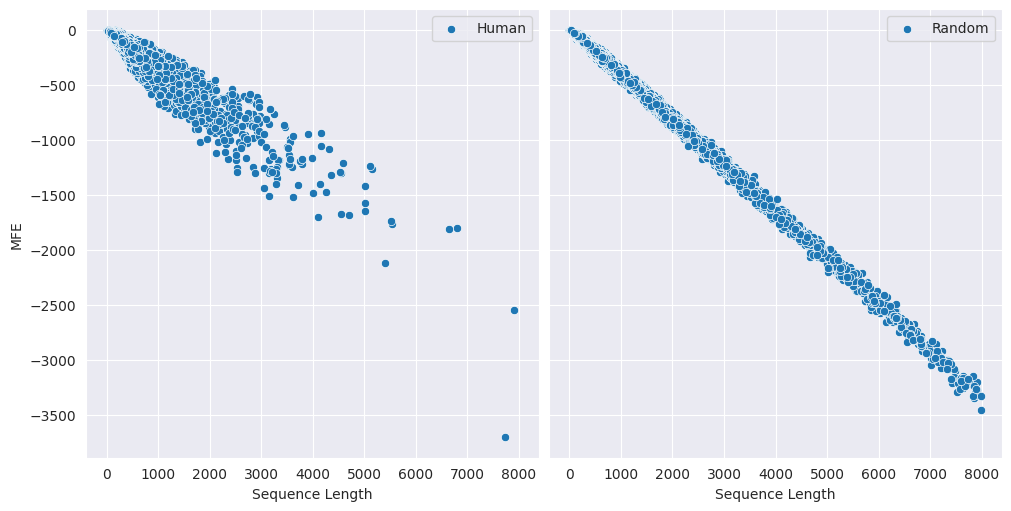

In [8]:
#MFE
fig5, axs5 = plt.subplots(1,2,layout='constrained',sharex=True,sharey=True,figsize=(10,5))
sns.scatterplot(humanseqs,x="Sequence Length",y="MFE",ax=axs5[0],label='Human')
sns.scatterplot(gc50dlseqs,x="Sequence Length",y="MFE",ax=axs5[1],label='Random')
plt.savefig('data/MFE.png')


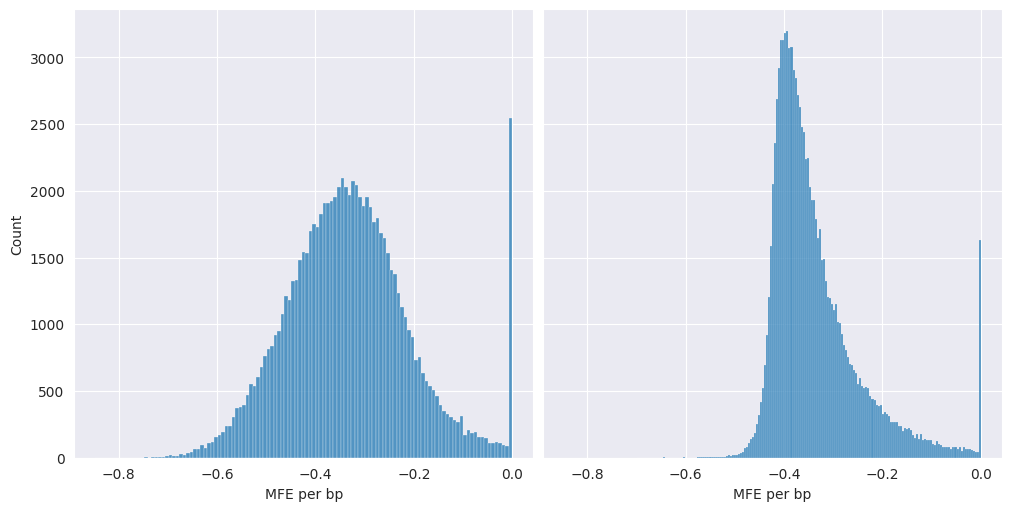

In [11]:
fig6, axs6 = plt.subplots(1,2,layout='constrained',sharex=True,sharey=True,figsize=(10,5))
sns.histplot(x=humanseqs["MFE"]/humanseqs["Sequence Length"],ax=axs6[0])
sns.histplot(x=gc50dlseqs["MFE"]/gc50dlseqs["Sequence Length"],ax=axs6[1])
for ax in axs6:
    ax.set_xlabel('MFE per bp')
plt.savefig('data/MFE_per_bp.png')

# Metadata

In [ ]:
'''Plot of runtimes of the uORF_statistics method over the size of the data (number or length of sequences)'''
times=[0.212,1.920,19.402,200.295]
sizes=[100,1000,10000,100000]
plt.plot(sizes,times)
plt.xlabel("Size of the data")
plt.ylabel("Time [s]")
plt.title("runtime of oORFs algorithm vs size of data")
plt.show()

In [ ]:
times=[0.021,0.256,37.857,3753]
sizes=[10,100,1000,10000]
plt.plot(sizes,times)
plt.xlabel("Size of the data")
plt.ylabel("Time [s]")
plt.title("runtime of outdated randomlengthseqs algorithm vs size of data")
plt.show()

# testing

In [ ]:
def testfunc(a,b):
    print(a+b)
def testingtestfunc(func,a,b):
    func(a,b)
    
testingtestfunc(testfunc,1,2)

In [ ]:
print(sum)

In [ ]:
rng = np.random.default_rng(seed=3)
a=rng.choice([0,1,3],3)
b=np.array([0,1,2,3])
for i in b[1:]:
    print(i)

In [ ]:
def lognormalfunc(x,myu,sigma,a):
    return a*np.exp(-1*(np.log(x)-myu)**2/(2*sigma)**2)/(x*sigma*np.sqrt(2*np.pi))

In [ ]:
sns.scatterplot(x=x_plot,y=lognormalfunc(x_plot,myu,sigma,factor_a),size=1,marker=".");

In [ ]:
x_plot=np.arange(1,8000)
distribution=lognormalfunc(x_plot,myu,sigma,factor_a)
distribution=distribution/sum(distribution)
#print(sum(distribution))
rng=np.random.default_rng()
lengths=rng.choice(x_plot, 100000 , p=distribution)

In [ ]:
im3=sns.histplot(lengths,kde=True)
im3.lines[0].set_color('crimson')


In [ ]:
im4=sns.scatterplot(x=x_plot,y=distribution,size=1,marker=".")
#im4.lines[0].set_color('crimson')

In [ ]:
lengthdata=list(humanseqs['Sequence Length'])
lengthdata=Counter(lengthdata)
x,y=[],[]
for i,j in lengthdata.items():
    x.append(i)
    y.append(j)
y=np.array(y)
sns.scatterplot(x=x,y=y,size=1,marker=".");

In [ ]:
params, cov_matrix= curve_fit(lognormalfunc,x,y)
x_plot=np.arange(1,8000)
plt.plot(x_plot,lognormalfunc(x_plot,params[0],params[1],params[2]))
plt.plot(x,y,linestyle='None',marker=".")

myu=params[0]
sigma=params[1]
factor_a=params[2]
print(myu,sigma,factor_a)


In [ ]:
def poissonfunc(x,lamb,a):
    return a*poisson.pmf(x,lamb)
params1, cov_matrix1 = curve_fit(poissonfunc,x,y)
x_plot1=(np.arange(0,8000))
plt.plot(x_plot1,poissonfunc(x_plot1,params1[0],params1[1]))
plt.plot(x,y,linestyle='None',marker=".")

In [ ]:
x_plot=np.arange(1,8000)
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

    
#plt.plot(x_plot,lognormalfunc(x_plot,myu,sigma))
#plt.plot(x_plot,softmax(lognormalfunc(x_plot,myu,sigma)))
#plt.plot(x_plot,scipy.special.softmax(lognormalfunc(x_plot,myu,sigma)))
print([sum(lognormalfunc(x_plot,myu,sigma)),sum(softmax(lognormalfunc(x_plot,myu,sigma)))])

In [ ]:
#New approach for uORFs function
def uORFs(seqs):
    frames=src.uORF_Statistics.codons(seqs)
    template={
        "uORFs":list(np.zeros(len(frames))),
        "ouORFs":list(np.zeros(len(frames))),
        "mean_uORF_length":list(np.zeros(len(frames))),
        
        "CUG_uORFs":list(np.zeros(len(frames))),
        "CUG_ouORFs":list(np.zeros(len(frames))),
        "mean_CUG_uORF_length":list(np.zeros(len(frames))),
        
        
        "GUG_uORFs":list(np.zeros(len(frames))),
        "GUG_ouORFs":list(np.zeros(len(frames))),
        "mean_GUG_uORF_length":list(np.zeros(len(frames))),
    }
    framedict={}
    for frame in range(3):
        framedict[f"frame{frame+1}"]=pd.DataFrame(template)
        for index in range(len(frames[f"frame{frame+1}"])):
            seq=frames[f"frame{frame+1}"][index]
            lengths=[]
            CUG_lengths=[]
            GUG_lengths=[]
            for codon in range(len(seq)):
                if seq[codon]=='AUG':
                    uORF_length=0
                    ouORF_bool=True
                    for nextcodon in range(len(seq)-codon-1):
                        uORF_length+=3
                        if seq[nextcodon+codon+1] in src.constants.stopcodons:
                            ouORF_bool=False
                            framedict[f"frame{frame+1}"].loc[index,"uORFs"]+=1
                            lengths.append(uORF_length)
                            break
                    if ouORF_bool:
                        framedict[f"frame{frame+1}"].loc[index,"ouORFs"]+=1
                        break
                    
                if seq[codon]=='CUG':
                    uORF_length=0
                    ouORF_bool=True
                    for nextcodon in range(len(seq)-codon-1):
                        uORF_length+=3
                        if seq[nextcodon+codon+1] in src.constants.stopcodons:
                            ouORF_bool=False
                            framedict[f"frame{frame+1}"].loc[index,"CUG_uORFs"]+=1
                            CUG_lengths.append(uORF_length)
                            break
                    if ouORF_bool:
                        framedict[f"frame{frame+1}"].loc[index,"CUG_ouORFs"]+=1
                        break
                        
                if seq[codon]=='GUG':
                    uORF_length=0
                    ouORF_bool=True
                    for nextcodon in range(len(seq)-codon-1):
                        uORF_length+=3
                        if seq[nextcodon+codon+1] in src.constants.stopcodons:
                            ouORF_bool=False
                            framedict[f"frame{frame+1}"].loc[index,"GUG_uORFs"]+=1
                            GUG_lengths.append(uORF_length)
                            break
                    if ouORF_bool:
                        framedict[f"frame{frame+1}"].loc[index,"GUG_ouORFs"]+=1
                        break
             
            if len(lengths)>0:
                framedict[f"frame{frame+1}"].loc[index,"mean_uORF_length"] = sum(lengths)/len(lengths)   
            
            if len(CUG_lengths)>0:
                framedict[f"frame{frame+1}"].loc[index,"mean_CUG_uORF_length"]=sum(CUG_lengths)/len(CUG_lengths)
            if len(GUG_lengths)>0:
                framedict[f"frame{frame+1}"].loc[index,"mean_GUG_uORF_length"]=sum(GUG_lengths)/len(GUG_lengths)
             
    counts=pd.DataFrame()
    
    for key in framedict:
        for column in framedict[key].columns:
            counts[f"{key}_{column}"] = framedict[key].loc[:,column]
            
    counts["uORFs"]=counts["frame1_uORFs"]+counts["frame2_uORFs"]+counts["frame3_uORFs"]
    counts["CUG_uORFs"]=counts["frame1_CUG_uORFs"]+counts["frame2_CUG_uORFs"]+counts["frame3_CUG_uORFs"]
    counts["GUG_uORFs"]=counts["frame1_GUG_uORFs"]+counts["frame2_GUG_uORFs"]+counts["frame3_GUG_uORFs"]
    counts["ouORFs"]=counts["frame1_ouORFs"]+counts["frame2_ouORFs"]+counts["frame3_ouORFs"]
    counts["CUG_ouORFs"]=counts["frame1_CUG_ouORFs"]+counts["frame2_CUG_ouORFs"]+counts["frame3_CUG_ouORFs"]
    counts["GUG_ouORFs"]=counts["frame1_GUG_ouORFs"]+counts["frame2_GUG_ouORFs"]+counts["frame3_CUG_ouORFs"]
    counts["all uORFs"]=counts["uORFs"]+counts["CUG_uORFs"]+counts["GUG_uORFs"]
    counts["all ouORFs"]=counts["ouORFs"]+counts["CUG_ouORFs"]+counts["GUG_ouORFs"]
    
    counts = counts.replace(0, np.nan)
    counts["mean_uORF_length"] = counts.loc[:,["frame1_mean_uORF_length","frame2_mean_uORF_length","frame3_mean_uORF_length"]].mean(axis=1)
    counts["mean_CUG_uORF_length"] = counts.loc[:,["frame1_mean_CUG_uORF_length","frame2_mean_CUG_uORF_length","frame3_mean_CUG_uORF_length"]].mean(axis=1)
    counts["mean_GUG_uORF_length"] = counts.loc[:,["frame1_mean_GUG_uORF_length","frame2_mean_GUG_uORF_length","frame3_mean_GUG_uORF_length"]].mean(axis=1)
    counts["all mean lengths"] = counts.loc[:,["mean_uORF_length","mean_CUG_uORF_length","mean_GUG_uORF_length"]].mean(axis=1)
    counts = counts.replace(np.nan, 0)

    cols_in_front = ["all uORFs","all ouORFs","all mean lengths","uORFs","CUG_uORFs","GUG_uORFs","ouORFs","CUG_ouORFs","GUG_ouORFs","mean_uORF_length","mean_CUG_uORF_length","mean_GUG_uORF_length"]
    counts = counts.loc[:,[c for c in cols_in_front if c in counts.columns] + [c for c in counts if c not in cols_in_front]]
    
    if type(seqs) == pd.core.frame.DataFrame:
        counts.insert(loc=0,column='SeqID',value=seqs.index)
        counts.set_index('SeqID', inplace=True)
    
    return counts

In [ ]:
singleseq="CACCCCGCUCGCGCCCAGCAGCGGACAUGCUCCACGAGCGCUGACAGCGUCGCCGUGCAACAAUCCUGGCGCCUGCCGCCGGCGAGCGGUCGACCGACCCGCACCGGUUCUCUAUGCCCCGCUACGGGCGGCCCGAGGCUUUACUACCCGGGCGCUUACC"
singleseq1="CCCGGCCGCGUCUGACUGCGCACCCCGCAAGUGUGUUGUCCCGCUCCCCAGCAGCCCCCCCCCCCCCCCGCUCGGCGCAGGGCCGAUCGCCACUUCCCUACCCGCGCGCCCACUUAUAGUCCCCGACUACCGUGCGCGGUUACUGCAGAAUGUCCGCCCCU"
#singleseqcodons=src.uORF_Statistics.codons(singleseq1)
counts=src.uORF_Statistics.uORFs(singleseq1)
counts.T



In [ ]:
singleseqcodons.T.to_csv("data/testcodons.csv",sep="\t",index=False)


In [ ]:
mydict={"frame1":[10,11,12],"frame2":[20,21,22],"frame3":[30,31,32]}
num=69
df=pd.DataFrame(mydict)
df2=pd.DataFrame()
df["mean"]=df.loc[:,["frame2","frame3"]].mean(axis=1)
df

In [ ]:
mydict1={"feature1":[0],"feature2":[0],"feature3":[0]}
template=pd.DataFrame(mydict1)
l=[]
for frame in range(3):
    r1=np.random.randint(1,10)
    r2=np.random.randint(1,10)
    r3=np.random.randint(1,10)
    df=pd.DataFrame(mydict1)
    df.loc[0,"feature1"]=r1
    df.loc[0,"feature2"]=r2
    df.loc[0,"feature3"]=r3
    l.append(df)
print(l[0])
print(l[1])
print(l[2])

In [ ]:
var1=10
var2=var1
var1=11
var2

In [ ]:
for i in range(10):
    print(i)
    if i ==5 :
        print("test")
        for j in range(3):
            print("test", 2)
            if j==1:
                print("break")
                break

In [ ]:
singleseq2="AGCGCAUGUAUGUAUGCUGCGCGC"
count=0
streaks=[]
streak=0
streakstart=False
for i in range(0,len(singleseq2),2):
    print(singleseq2[i:i+2])
    if singleseq2[i:i+2]=="GC" or singleseq2[i:i+2]=="CG":
        count+=1
        if i>=2 and singleseq2[i-2:i]==singleseq2[i:i+2]:
            streak+=2
    else:
        if streak > 0:
            streaks.append(streak)
            streak=0
for i in range(1,len(singleseq2),2):
    print(singleseq2[i:i+2])
    if singleseq2[i:i+2]=="GC" or singleseq2[i:i+2]=="CG":
        count+=1
        if i>=2 and singleseq2[i-2:i]==singleseq2[i:i+2]:
            streak+=2
    else:
        if streak > 0:
            streaks.append(streak)
            streak=0

print(count,streaks)
    
        
        

In [ ]:
def fast_uORfs(seqs,startcodon):
    
    seq_pos={"frame1":[],"frame2":[],"frame3":[]}
    if type(seqs)== pd.DataFrame:
        seqstrings=seqs["Sequence"].values
    if type(seqs)== str:
        seqstrings=[seqs]
    len_loop=len(seqstrings)
    template = {
        "uORFs": list(np.zeros(len_loop)),
        "ouORFs": list(np.zeros(len_loop)),
        "mean_uORF_length": list(np.zeros(len_loop)),
        "max_uORF_length": list(np.zeros(len_loop)),
        
        "frame1_uORFs": list(np.zeros(len_loop)),
        "frame1_ouORFs": list(np.zeros(len_loop)),
        "frame1_mean_uORF_length": list(np.zeros(len_loop)),
        "frame1_max_uORF_length": list(np.zeros(len_loop)),
        
        "frame2_uORFs": list(np.zeros(len_loop)),
        "frame2_ouORFs": list(np.zeros(len_loop)),
        "frame2_mean_uORF_length": list(np.zeros(len_loop)),
        "frame2_max_uORF_length": list(np.zeros(len_loop)),
        
        "frame3_uORFs": list(np.zeros(len_loop)),
        "frame3_ouORFs": list(np.zeros(len_loop)),
        "frame3_mean_uORF_length": list(np.zeros(len_loop)),
        "frame3_max_uORF_length": list(np.zeros(len_loop)),
    }
    counts=pd.DataFrame(template)
    
    posdict={"frame1":[[] for _ in range(len(seqstrings))],"frame2":[[] for _ in range(len(seqstrings))],"frame3":[[] for _ in range(len(seqstrings))]}
    for index in range(len(seqstrings)):
        seq=seqstrings[index]
        for i in range(len(seq)):
            rev_i=len(seq)-i
            frame=(rev_i%3)
            if seq[i:i+3]==startcodon:
                posdict[f'frame{frame+1}'][index].append(i+1)
            if seq[i:i+3]in src.constants.stopcodons:
                posdict[f'frame{frame+1}'][index].append((i+1)*-1) 

    
    for frame in range(3):
        poslist=posdict[f'frame{frame+1}']
        for index in range(len_loop):
            pos=poslist[index]
            if len(pos)>1:
                lengths=[]
                if pos[-1]>0:
                    counts.loc[index,"ouORFs"]+=1
                    counts.loc[index,f"frame{frame+1}_ouORFs"]+=1
                    
                for i in range(len(pos)):
                    if pos[i]>0:
                    
                        for j in range(len(pos)-i-1):        
                            if pos[i+j+1]<0:
                                
                                counts.loc[index,"uORFs"]+=1
                                counts.loc[index,f"frame{frame+1}_uORFs"]+=1
                                lengths.append((pos[i]+pos[i+j+1])*-1+3)
                                break
                if len(lengths)>0:
                    counts.loc[index,f"frame{frame+1}_mean_uORF_length"]=sum(lengths)/len(lengths)
                    counts.loc[index,f"frame{frame+1}_max_uORF_length"]=max(lengths)
                if len(pos)==1 and pos[0]>0:
                    counts.loc[index,"ouORFs"]+=1
                    counts.loc[index,f"frame{frame+1}_ouORFs"]+=1
                    
                    
                    
    
    counts["mean_uORF_length"]=counts.loc[:,["frame1_mean_uORF_length","frame2_mean_uORF_length","frame3_mean_uORF_length"]].mean(axis=1)
    counts["max_uORF_length"]=counts.loc[:,["frame1_max_uORF_length","frame2_max_uORF_length","frame3_max_uORF_length"]].max(axis=1)
    
    return counts
                 

In [ ]:
singleseq="AUGGCCGCAUAAAGAUGGAAUAGC"

In [ ]:
AUG_counts2=fast_uORfs(seqs,'AUG')

In [ ]:

CUG_counts2=fast_uORfs(seqs,'CUG')
GUG_counts2=fast_uORfs(seqs,'GUG')
counts2=src.uORF_Statistics.counts_concat_all(seqs,AUG_counts2,CUG_counts2,GUG_counts2)
counts2

In [ ]:
counts1

In [ ]:
seqstrings[-1]

In [ ]:
l="AUGUGAUAAAUGCAGAU"
frame1=[]
frame2=[]
frame3=[]
for i in range(len(l)-2):
    rev_i=len(l)-i
    if  rev_i%3==0:
        frame1.append(l[i]+l[i+1]+l[i+2])
    if rev_i %3==1:
        frame2.append(l[i]+l[i+1]+l[i+2])
    if rev_i %3==2:
        frame3.append(l[i]+l[i+1]+l[i+2])
print(frame1,'\n',frame2,'\n',frame3)        

In [ ]:
l=[3,21,24,2,1,2,0,-1,4]
print(max(l))

In [ ]:
l300=np.arange(400)
for i in range(4000):
    for i in range(len(l300)):
        for j in range(len(l300)-1):
            a=i+j


In [10]:
human160seqs = humanseqs[humanseqs["Sequence Length"] >= 160]
human160seqs

,Sequence,Group,Sequence Length,MFE,ss
SeqID,,,,,
ENST00000616016.5,GGCGGCGGAGUCUCCCAAGUCCCCGCCGGGCGGGCGCGCGCCAGUG...,Human,509,-321.000000,(((((.(((.(......).)))))))).(((((((((.(((........
ENST00000624697.4,CGGCCUCACGCGUCCGUGCAGCGGAGGCUUCCUGAGCCCCCUGGAG...,Human,251,-90.099998,.....((((.((.((((((((.((.(((((...))))))))))......
ENST00000624652.1,ACGCGUCCGUGCAGCGGAGGCUUCCUGAGCCCCCUGGAGAGCCUGG...,Human,226,-85.199997,...((.((((((((.((.(((((...))))))))))....(((..(...
ENST00000620552.4,CCCGUCCCCGGCGCGGCCCGCGCGCUCCUCCGCCGCCUCUCGCCUG...,Human,464,-222.500000,..........(((((...))))).((((((((((((.(((.((.((...
ENST00000651234.1,UGCCCGCUCCUAUCGCCGCUUCCGCCUCUGCCGGGGACGGGGACAG...,Human,450,-232.300003,.(((((((((..(((((.(.(((((((((...((((.(((((((((...
...,...,...,...,...,...
ENST00000382867.4,GUAACAGGCAGGAAGAAAGCUUUCUGUACUACACCAGAGGGUUGGG...,Human,328,-100.599998,(((....((((((((....))))))))..)))..((..((((((((...
ENST00000541639.5,CAUUUUAAAAAAGAUCCGGCCAUACUAUUUUUAUCUUGCUUUUUCG...,Human,288,-78.400002,..............((.((((...............((((...(((...
ENST00000440077.5,CGGCCAUACUAUUUUUAUCUUGCUUUUUCGUUCUGUCGCAGUACUG...,Human,272,-77.500000,.((((...............((((...((((.(((((((.(.(((....


In [12]:
human160seqs['Sequence_adjusted']=humanseqs['Sequence']

/tmp/ipykernel_3718831/3070353032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
